## **Imports**

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel
from datasets import Dataset
import re
from tqdm import tqdm
import paths_ml_task_1 as PATHS
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

# **Experiment: Evaluating Vectorization and Embedding Strategies for Political Speech Classification**

**TL;DR:**
This experiment evaluates vectorization and embedding methods for classifying political speeches by party affiliation. It seperateley compares TF-IDF and DOC2Vec Vectors for classical machine learning using a Support Vector Machine and CLS-token vs. Mean Pooling embedding strategies for deep learning models using BERT. Subsequently, the optimal embedding strategy identified will be used to determine weather the Truncating or the Sliding Window Method the best approach for handling speeches exceeding BERT's 512-token limit.


---


## **Objective, Assumptions, Context and Motivation**

The primary goal of this experiment is to analyze and compare the performance impacts of different vectorization and embedding strategies on the accuracy and robustness of models classifying party affiliation of political speeches from the German Bundestag. Specifically, we seek to identify optimal vectorization methods that best represent semantic and rhetoric nuances necessary for accurate classification.

### **Vectorization Techniques for classic ML Models: TF-IDF vs. DOC2Vec**

- The **Term Frequency-Inverse Document Frequency (TF-IDF)** method quantifies the importance of terms within individual documents relative to their rarity across the entire corpus. TF-IDF primarily considers statistical significance by assigning higher weights to words frequent in a particular speech but uncommon in others. However, it does not inherently capture semantic relationships or context, potentially overlooking nuanced linguistic subtleties necessary for accurately distinguishing political rhetoric.

- In contrast, **DOC2Vec**, an extension of the Word2Vec model, represents entire speeches as dense vectors by capturing semantic relationships through neural embedding techniques. DOC2Vec leverages context prediction tasks to embed speeches in a latent semantic space, thus preserving contextual and thematic continuity. This embedding method potentially captures deeper semantic structures, which are especially pertinent in politically charged and contextually nuanced discourse.

### **Embedding Strategies for BERT models: Standard CLS-Token embedding vs. Mean Pooling**

Pertinent literature presents conflicting evidence regarding the superiority of these embedding methods. If interested you can find some shorter publications on the subject of BERT embedding strategies [here](https://milvus.io/ai-quick-reference/how-does-the-choice-of-pooling-strategy-mean-pooling-vs-using-the-cls-token-potentially-affect-the-quality-of-the-embeddings-and-the-speed-of-computation) and [there](http://arno.uvt.nl/show.cgi?fid=169299).

- **The `[CLS]` token embedding**, explicitly trained during BERT's pretraining phase to summarize entire inputs, serves as a compressed semantic representation and often performs strongly in fine-tuned tasks like classification by effectively isolating task-specific features. Nevertheless, its effectiveness is tightly coupled with the similarity between pretraining and downstream fine-tuning objectives, potentially limiting adaptability.

- Conversely, **the Mean Pooling embedding** aggregates embeddings across all tokens, aiming to encapsulate a comprehensive semantic overview of the input text. While it effectively captures broader contexts and thematic consistencies, mean pooling can inadvertently blend irrelevant or noisy elements with key tokens, thereby diluting critical semantic signals, especially within shorter or highly variable speech segments. Its generally robust contextual capture, however, may prove superior in processing complex, extended political speeches.

Given these conflicting viewpoints, we first aim to empirically evaluate which embedding method — CLS or mean pooling — provides superior performance in our specific task context. The most effective embedding method identified from this comparison will subsequently be utilized to explore the optimal handling strategy for longer speeches.

### **Handling Long Speeches in BERT: Sliding Window vs. Truncation Approach**

The Sliding Window method addresses the intrinsic token-length limitation (512 tokens) of BERT models by segmenting speeches exceeding this threshold into overlapping segments. Each segment maintains semantic continuity by partially overlapping with neighboring segments. The resulting embeddings are then sequentially processed to preserve broader contextual coherence.

While advantageous for retaining extended context, essential in political speeches with complex argumentative structures, the sliding window approach introduces computational overhead and complexity.

Conversely, strict truncation at the 512-token limit offers computational simplicity but risks losing critical contextual and argumentative nuances essential for accurate classification.


---


## **Experimental Design**

### **Dataset Configuration:**

- **Data Source for all models:** All speeches from the 20th electoral term, taken from the `speech_content` column of `data/dataFinalStage/speechContentFinalStage/speech_content_20.pkl`.
- **Class Selection & Preprocessing:**
    - Before training all `BSW` samples are merged into `DIE LINKE.` and contribution position markers are removed.
    - Unassigned speeches with `faction_id=-1` as well as speeches by `Fraktionslos` with `faction_id=18` are removed.
    - The final 6 class labels are `AfD`, `Bündnis 90/Die Grünen`, `CDU/CSU`, `DIE LINKE.`, `FDP` and `SPD`.
- **Train-Test Split:** One stratified 80/20 split with fixed random seed for reproducibility is used for **all models**. The trained models are evaluated on the 20 % hold-out set.
- **Sampling Strategy:**
  - Initial length-based filtering removes speeches outside the central 65 % speech length range: the shortest (lower 25 % quantile) and longest (upper 90 % quantile) speeches are excluded.
  - After filtering, 1000 speeches per party are randomly selected, eliminating class imbalance biases. Special care is taken to select samples with a representative distribution of speech lengths within the retained length spectrum.

> **Rationale for Length-Based Filtering:**
> - Removal of very short speeches (<25th percentile): Our [Speech Length Experiment](ML-Task-1_Speech-Length-Experiment.ipynb) indicated, that short speeches lack sufficient semantic context necessary for reliable classification.
> - Removal of very long speeches (>90th percentile): Extremely long speeches may contain redundant, tangential information that dilutes core semantic signals, complicating effective vectorization.
> Our previous speech-length analysis demonstrated that the majority of speeches cluster consistently within a central length range (approximately 100–1000 tokens). Removing extreme lengths through percentile-based filtering thus ensures a representative, balanced, and semantically-rich dataset suitable for evaluating embedding methods, mitigating biases caused by excessively sparse or overly verbose speeches.

### **Model Comparisons:**

| Models                                     | Comparisons                                                         |
|--------------------------------------------|---------------------------------------------------------------------|
| Classical ML Model: Support Vector Machine | Vectorization strategy: TF-IDF Vectorization vs. DOC2Vec Embeddings |
| Deep Learning Model: BERT                  | Embedding generation: CLS-Token Embedding vs. Mean Pooling          |
| Deep Learning Model: BERT                  | Long speech handling: Cut-off Method vs Sliding Window Approach     |

### **Shared Architecture and Configuration for BERT-based Classifiers: CLS-Token Embedding vs. Mean Pooling**

To ensure comparability between the BERT-based classification strategies, we standardize the architecture and training hyperparameters as follows:

- **BERT Backbone:** Both models use bert-base-german-cased from HuggingFace Transformers as pretrained encoder. The encoder outputs are passed to a custom linear classification head.
- Classifier Variants with different embedding strategies:
    1. **`BertClsPoolingClassifier`:** Extracts the `[CLS] token representation from the last hidden state (`last_hidden_state[:, 0, :]) and feeds it into a linear classification layer.
    2. **`BertMeanPoolingClassifier`:** Computes the mean of all token embeddings, weighted by the attention mask, to obtain a sentence embedding before applying the linear classifier.
- **Tokenizer:** `BertTokenizer` from HuggingFace, configured with `padding="max_length"` and `truncation=True` to enforce a hard 512 tokens input-length limit.
- **Training Hyperparameters:**
  - Epochs: 3
  - Batch size: 8
  - Learning rate: 1e-5
  - Evaluation strategy: `epoch`
  - Evaluation and prediction steps use HuggingFace's Trainer API
  - Optimizer: AdamW (implicitly used by the Trainer)
  - Fixed `random_seed` (`SEED = 42`)


### **Configuration of the SVM models: TF-IDF Vectorization vs. DOC2Vec Embeddings**

- **Model:** Linear Support Vector Machine (`LinearSVC` from scikit-learn with a fixed `random_state=42`)
- **TF-IDF Vectorizer Settings:**
  - `ngram_range=(1, 3)` → unigrams to trigrams
  - `max_features=50000`
  - `min_df=3` → removes very rare words
  - `max_df=0.5` → removes overly frequent, generic words
- **`Doc2Vec (gensim) Settings:**
    - `vector_size = 300`
    - `window = 5`
    - `min_count = 3`
    - `epochs = 20`
    - `workers = 4`
    - `seed = 42`
- **Additional Preprocessing of speech text:** Light preprocessing (lowercasing speech texts in addition to the already removed contribution position markers) helps reduce noise in lexical vectors without harming interpretability. (Note: TF-IDF vectors become very sparse with short samples.)


---


## **Evaluation Strategy**

- **Macro-F1 and Accuracy** provide general indicators of overall predictive effectiveness and balanced performance across classes. Higher Macro-F1 indicates models better balanced across all political factions, critical for fair analytical interpretations.

- **Per-Class Precision and Recall** reveal detailed party-specific insights, enabling identification of performance disparities and indicating potential biases in classification.

- **The Confusion Matrix** facilitates a qualitative examination of common misclassifications, highlighting semantic ambiguities or thematic overlaps among parties that models struggle to differentiate.

- **Qualitatively**, we aim to discern whether enhanced semantic completeness and contextual retention (via DOC2Vec and sliding window embeddings) significantly correlate with improved classification performance. This would validate the theoretical advantage of these approaches in capturing the sophisticated semantic structures of political discourse.

This structured, comparative evaluation aims to rigorously identify the optimal vectorization and embedding strategies that effectively capture the complex semantic structures inherent in political speech, thereby significantly advancing our models' robustness and accuracy.



Counting tokens: 100%|██████████| 32042/32042 [01:19<00:00, 400.96it/s]


Removed 11190 speeches due to outlier speech length. 20852 speeches remain.


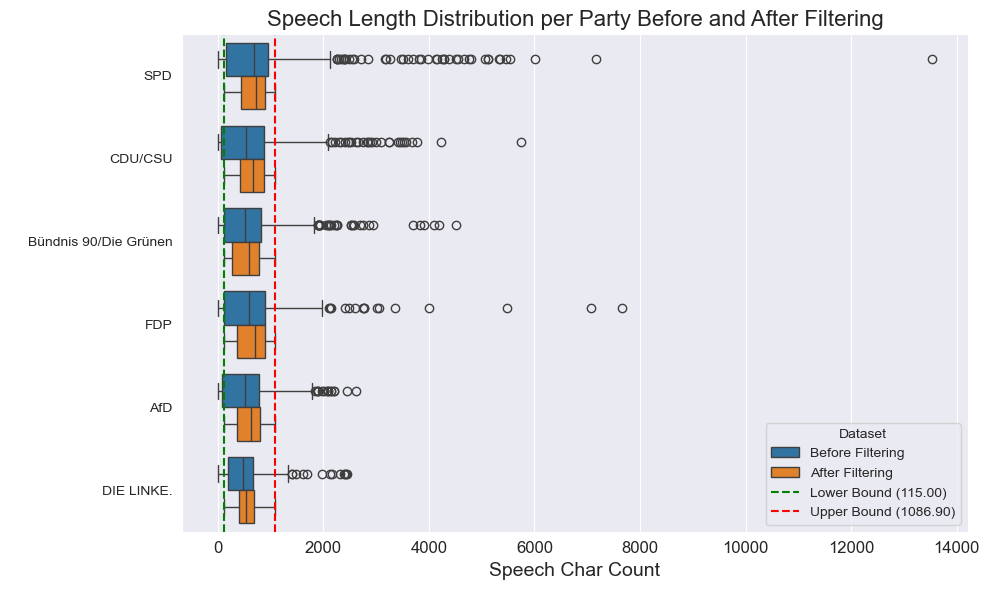


Classification Report SVM_TFIDF:
                       precision  recall  f1-score   support
AfD                        0.787   0.850     0.817   200.000
Bündnis 90/Die Grünen      0.561   0.505     0.532   200.000
CDU/CSU                    0.672   0.645     0.658   200.000
DIE LINKE.                 0.734   0.840     0.783   200.000
FDP                        0.579   0.515     0.545   200.000
SPD                        0.546   0.560     0.553   200.000
accuracy                   0.652   0.652     0.652     0.652
macro avg                  0.646   0.652     0.648  1200.000
weighted avg               0.646   0.652     0.648  1200.000
                       precision  recall  f1-score   support
AfD                        0.379   0.750     0.503   200.000
Bündnis 90/Die Grünen      0.347   0.290     0.316   200.000
CDU/CSU                    0.274   0.155     0.198   200.000
DIE LINKE.                 0.416   0.435     0.425   200.000
FDP                        0.310   0.270     0.289 

Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_18405/3621965486.py:225: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,1.515600
1000,1.176500
1500,0.956900


/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Classification Report BERT_CLS:
                       precision  recall  f1-score   support
AfD                        0.892   0.580     0.703   200.000
Bündnis 90/Die Grünen      0.492   0.435     0.462   200.000
CDU/CSU                    0.493   0.540     0.516   200.000
DIE LINKE.                 0.575   0.820     0.676   200.000
FDP                        0.424   0.350     0.384   200.000
SPD                        0.397   0.445     0.420   200.000
accuracy                   0.528   0.528     0.528     0.528
macro avg                  0.546   0.528     0.527  1200.000
weighted avg               0.546   0.528     0.527  1200.000


Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_18405/3621965486.py:304: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,1.491900
1000,1.113900
1500,0.877700


/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Classification Report BERT_MEAN:
                       precision  recall  f1-score   support
AfD                        0.871   0.640     0.738   200.000
Bündnis 90/Die Grünen      0.494   0.420     0.454   200.000
CDU/CSU                    0.525   0.585     0.553   200.000
DIE LINKE.                 0.571   0.860     0.687   200.000
FDP                        0.517   0.370     0.431   200.000
SPD                        0.444   0.480     0.462   200.000
accuracy                   0.559   0.559     0.559     0.559
macro avg                  0.570   0.559     0.554  1200.000
weighted avg               0.570   0.559     0.554  1200.000
### Confusion Matrices (Raw Counts)

#### SVM_TFIDF
| True \ Pred | AfD | Bündnis 90/Die Grünen | CDU/CSU | DIE LINKE. | FDP | SPD |
|----|----|----|----|----|----|----|
| AfD | 170 | 3 | 9 | 15 | 2 | 1 |
| Bündnis 90/Die Grünen | 6 | 101 | 9 | 20 | 24 | 40 |
| CDU/CSU | 15 | 9 | 129 | 8 | 17 | 22 |
| DIE LINKE. | 10 | 5 | 8 | 168 | 5 | 4 |
| FDP | 8 | 2

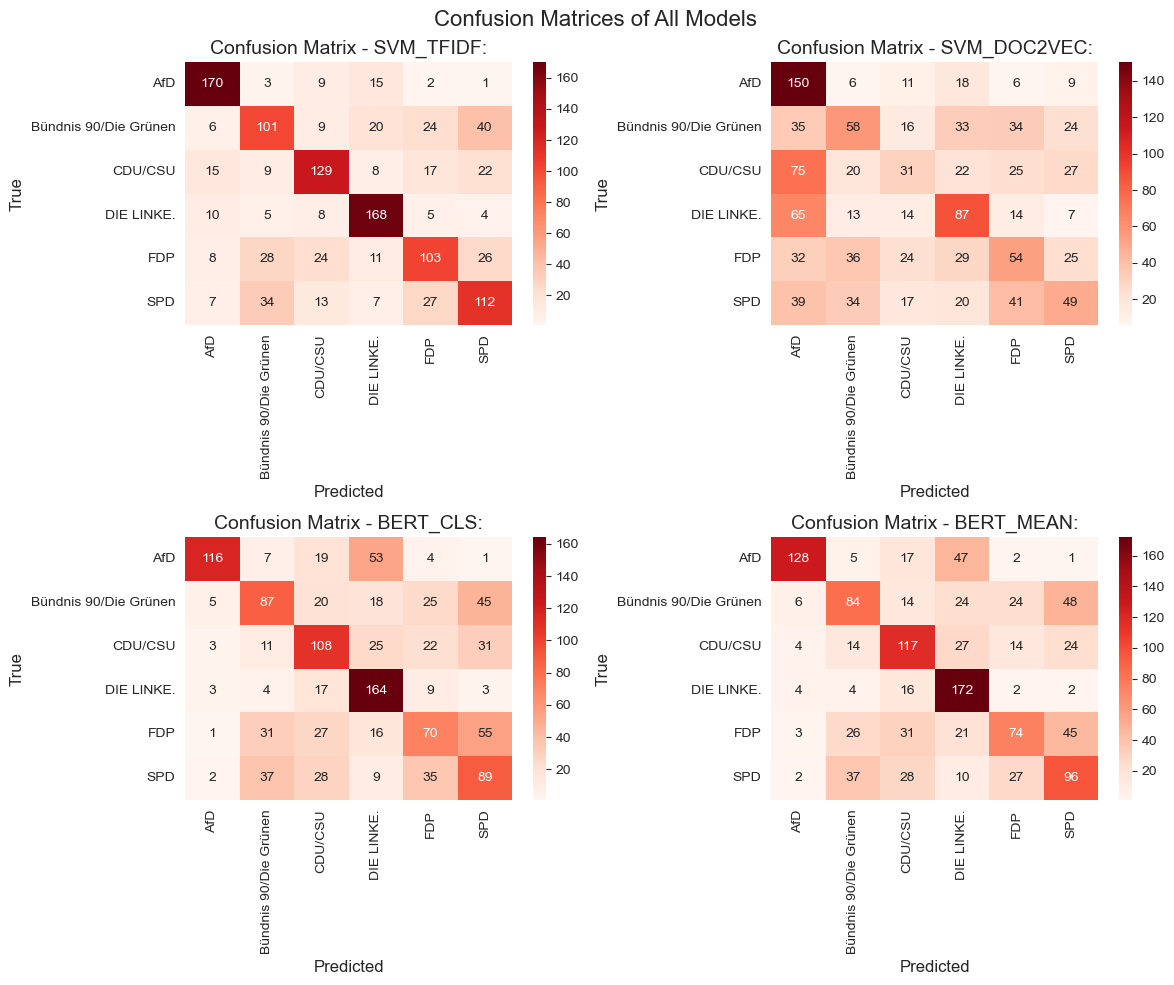

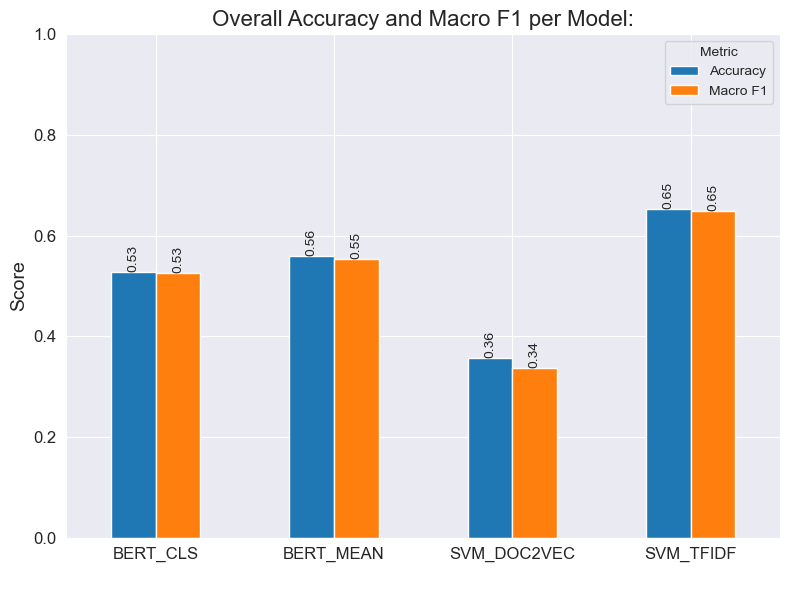

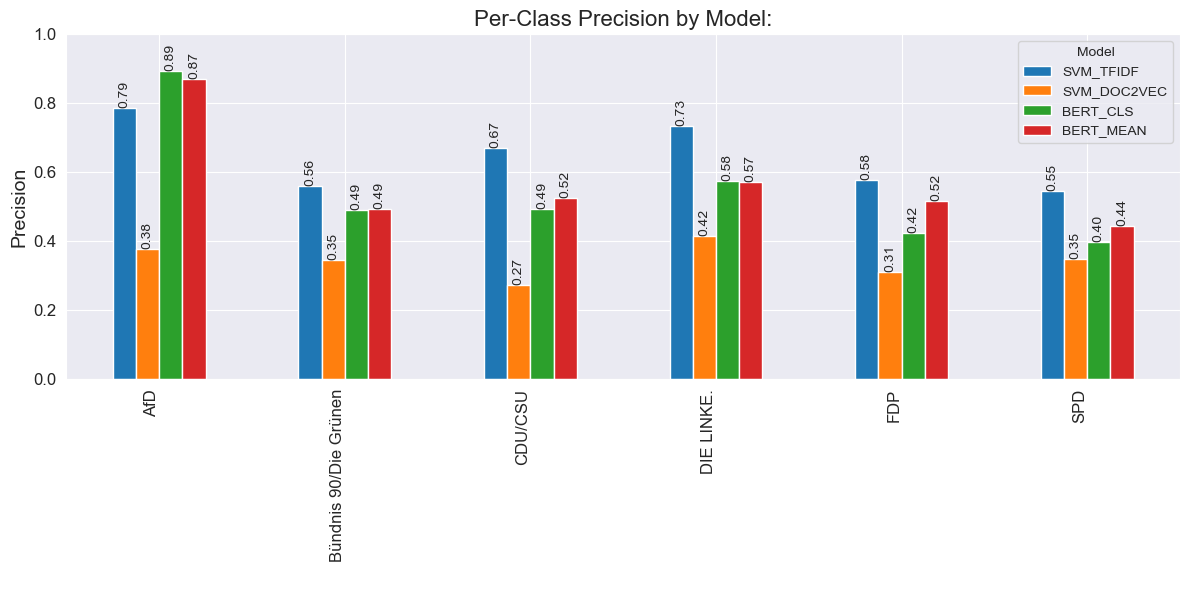

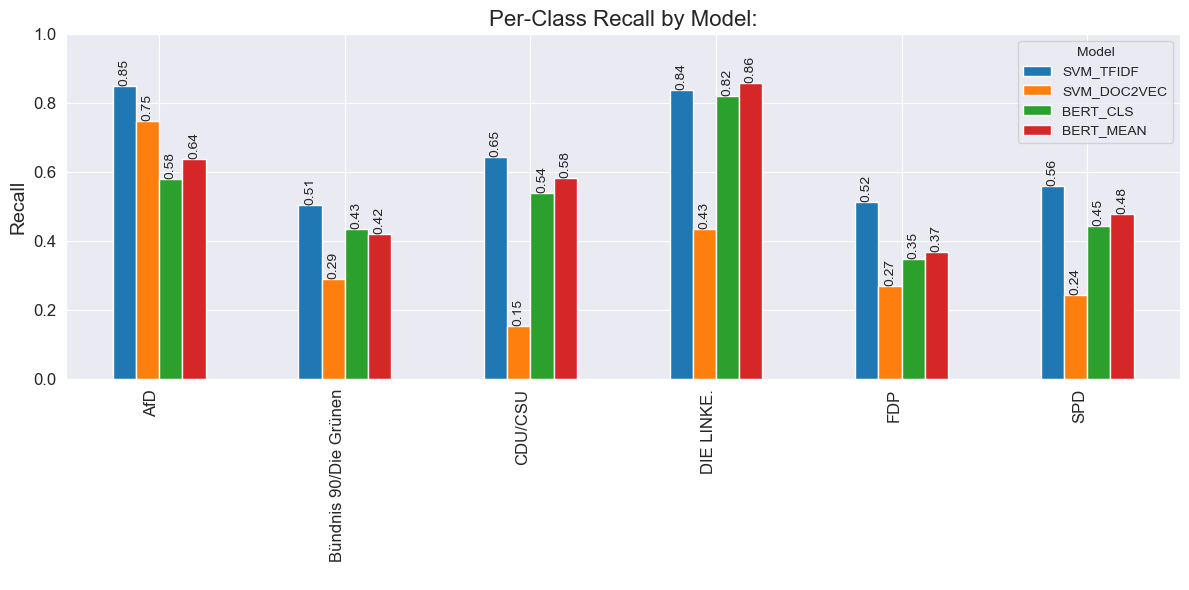

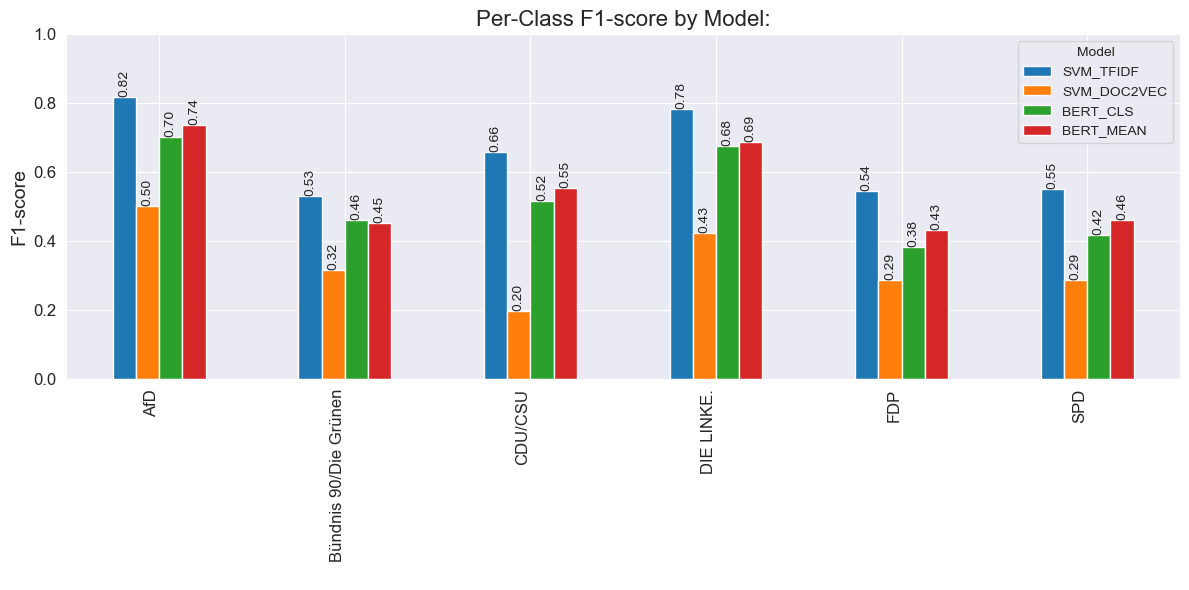


### Summary of F1-scores per Class:
                       SVM_TFIDF  SVM_DOC2VEC  BERT_CLS  BERT_MEAN
AfD                        0.817        0.503     0.703      0.738
Bündnis 90/Die Grünen      0.532        0.316     0.462      0.454
CDU/CSU                    0.658        0.198     0.516      0.553
DIE LINKE.                 0.783        0.425     0.676      0.687
FDP                        0.545        0.289     0.384      0.431
SPD                        0.553        0.287     0.420      0.462
accuracy                   0.652        0.358     0.528      0.559
macro avg                  0.648        0.337     0.527      0.554
weighted avg               0.648        0.337     0.527      0.554


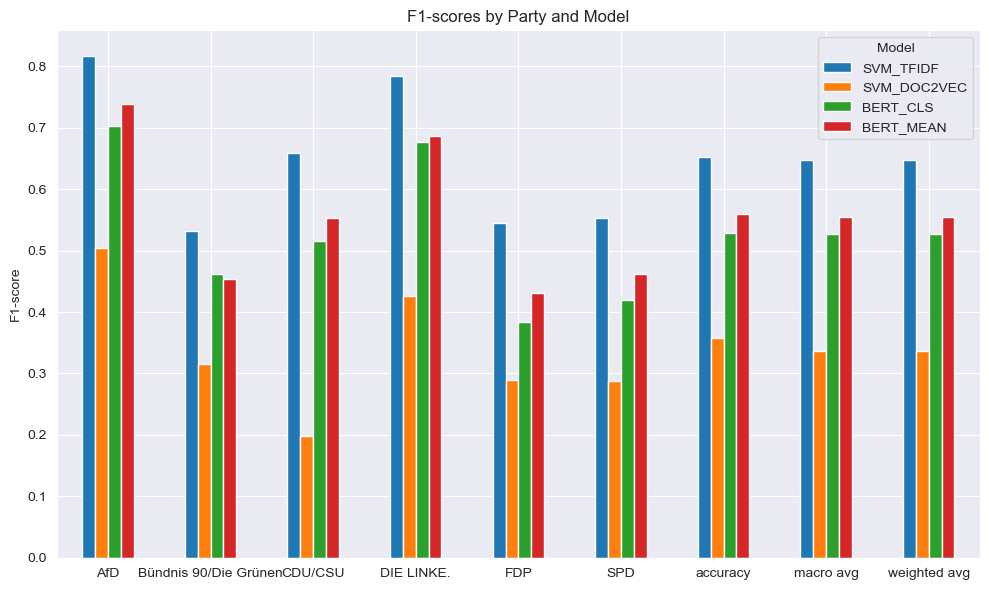


Summary of classification reports:
                       SVM_TFIDF  SVM_DOC2VEC  BERT_CLS  BERT_MEAN
AfD                        0.817        0.503     0.703      0.738
Bündnis 90/Die Grünen      0.532        0.316     0.462      0.454
CDU/CSU                    0.658        0.198     0.516      0.553
DIE LINKE.                 0.783        0.425     0.676      0.687
FDP                        0.545        0.289     0.384      0.431
SPD                        0.553        0.287     0.420      0.462
accuracy                   0.652        0.358     0.528      0.559
macro avg                  0.648        0.337     0.527      0.554
weighted avg               0.648        0.337     0.527      0.554


In [7]:
class BertClsPoolingClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = output.last_hidden_state[:, 0, :]  # CLS Token
        logits = self.classifier(cls_output)
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}



class BertMeanPoolingClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = output.last_hidden_state # (B, L, H)
        mask = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
        summed_vectors = (hidden_states * mask).sum(dim=1)   # (B, H)
        valid_tokens   = mask.sum(dim=1) # (B, 1)
        mean_pooled    = summed_vectors / torch.clamp(valid_tokens, min=1e-9)
        logits = self.classifier(mean_pooled) # classification
        # loss:
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}



"""
Setup constants
"""
# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# Models & Tokenizer
MODEL_NAME = "bert-base-german-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
LEARNING_RATE = 1e-5
NUM_LABELS = 6  # will later also be adjustet based on the number of uniqe parties in the dataset
BATCH_SIZE = 8
EPOCHS = 3
MAX_SAMPLE_SIZE_PARTY=1000 # speech counts of parties need to be double checked after filtering
TEST_SPLIT_SIZE=0.2
MAX_FEATURES = 50000
NGRAM_RANGE = (1, 3)
MIN_DF = 3
MAX_DF = 0.5
UPPER_PERCENTILE = 0.9
LOWER_PERCENTILE = 0.25
MAX_LENGTH_BERT = 512



"""
Global variables
"""
# Global dictionary to store all confusion matrices by model name
confusion_matrices = {}
# Global dictionary to collect classification reports per model
classification_reports = {}
# Load faction map
faction_map = pd.read_pickle(PATHS.FINAL_FACTIONS_ABBREVIATIONS).drop_duplicates(subset="id").set_index("id")["abbreviation"]
# Set device type explicitly for MPS (Apple Silicon), CUDA or CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")



"""
Tokenization and dataset conversion
"""
def turn_lower_case(text: str) -> str:
        """
        Normalizes text to lowercase and collapses whitespace for TF-IDF vectorization

        :param text (str): Raw speech text
        :return text (str): Normalized speech text
        """
        if not isinstance(text, str):
            return text  # Skip non-string entries (if any)
        text = text.lower()
        text = re.sub(r"\s+", " ", text)
        return text.strip()


def remove_contribution_markers(text: str) -> str:
    """
    - collapses whitespace
    - Removes content in square brackets like [Beifall], [Zwischenruf], etc.
    - Removes contribution position placeholders in the form of ({123})

    :param text (str): Raw speech text
    :return text (str): Normalized speech text
    """
    if not isinstance(text, str):
        return text  # Skip non-string entries (if any)
    text = re.sub(r'\[.*?\]', ' ', text, flags=re.IGNORECASE | re.MULTILINE)
    text = re.sub(r'\(\{\d+\}\)', ' ', text, flags=re.IGNORECASE | re.MULTILINE)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


def tokenize_function(examples, max_length):
    """
    Tokenizes input text using BertTokenizer with specific max token length.

    :param: examples (dict): Dictionary containing the key "speech_content" with raw text.
    :param: max_length (int): Maximum number of tokens after padding/truncation.

    :return: tokenized_output (dict): Dictionary with input_ids and attention masks.
    """
    return tokenizer(examples["speech_content"], padding="max_length", truncation=True, max_length=max_length)


def prepare_dataset_BERT(df_subset, max_len):
    """
    Prepares and tokenizes dataset from dataframe for BERT model training.

    :param: df_subset (pd.DataFrame): DataFrame containing speeches and encoded labels.
    :param: max_len (int): Maximum token length.

    :return: df_tokenized (Dataset): Tokenized and formatted dataset compatible with PyTorch.
    """
    df_subset["speech_content"] = df_subset["speech_content"].apply(remove_contribution_markers)
    df_dataset = Dataset.from_pandas(df_subset[["speech_content", "label_encoded"]])
    df_tokenized = df_dataset.map(lambda x: tokenize_function(x, max_len), batched=True)
    df_tokenized = df_tokenized.rename_column("label_encoded", "labels")

    cols = ["input_ids", "attention_mask", "labels"]
    if "token_type_ids" in df_tokenized.column_names:
        cols.append("token_type_ids")
    df_tokenized.set_format(type="torch", columns=cols)
    return df_tokenized


def bert_mean_pooling(model_output, attention_mask):
    """
    Computes the mean-pooled sentence embedding from a BERT model output.
    This function applies mean pooling over the token embeddings produced by a BERT model,
    taking the attention mask into account to exclude padding tokens from the average.
    The result is a fixed-size vector representation for the entire input sequence.

    :param: model_output(torch.Tensor or tuple): The output from the BERT model. Typically a tuple where
        the first element (index 0) contains the token embeddings of shape (batch_size, seq_len, hidden_dim).
    :param: attention_mask (torch.Tensor): A binary mask of shape (batch_size, seq_len), where 1 indicates
        valid (non-padding) tokens and 0 indicates padding tokens.

    :return: mean_pooled_embedding (torch.Tensor): A tensor of shape (batch_size, hidden_dim) representing
        the mean-pooled embedding for each input sequence.
    """
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


def prepare_dataset_svm(df_subset):
    """
    Prepares adataset for SVM models.

    :param: df_subset (pd.DataFrame): DataFrame containing speeches and labels.
    :param: max_len (int): Maximum token length.

    :return: df_normalized (Dataset): Formatted dataset.
    """
    df_normalized = df_subset.copy() # copying to remove SettingWithCopyWarning
    df_normalized["speech_content"] = df_normalized["speech_content"].apply(remove_contribution_markers)
    df_normalized["speech_content"] = df_normalized["speech_content"].apply(turn_lower_case)
    return df_normalized


def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }


"""
Training Loop for BERT on CLS token embeddings
"""
def train_bert_cls(train_df, test_df, model_name):
    """
    Training Loop for BERT

    :param: train_df (Dataset): training dataset.
    :param: test_df (Dataset): testing dataset.
    :param: model_name (str): Identifier for logging and visualizations.

    :return: None
    """
    train_ds = prepare_dataset_BERT(train_df, MAX_LENGTH_BERT)
    test_ds = prepare_dataset_BERT(test_df, MAX_LENGTH_BERT)

    # Initialize BERT model and trainer and move to device
    model = BertClsPoolingClassifier(MODEL_NAME, num_labels=NUM_LABELS)
    model.to(device)

    # Set training arguments for the HuggingFace trainer
    training_args = TrainingArguments(
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
    )

    # Trainer object initialization
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # train model
    trainer.train()

    # Predicting and decoding labels
    preds = trainer.predict(test_ds)
    y_true = encoder.inverse_transform(preds.label_ids)
    y_pred = encoder.inverse_transform(np.argmax(preds.predictions, axis=1))

    # Map to faction abbreviations
    y_true_abbr = [faction_map.get(label, str(label)) for label in y_true]
    y_pred_abbr = [faction_map.get(label, str(label)) for label in y_pred]

    # unique labels and abbr
    unique_labels=sorted(np.unique(y_true))
    unique_abbr=sorted(np.unique(y_true_abbr))


    # Calculate and store confusion matrix globally
    cm_local = confusion_matrix(y_true, y_pred, labels=unique_labels)
    # Store for later plotting
    confusion_matrices[model_name] = {
        "matrix": cm_local,
        "labels": unique_abbr
    }


    # Classification Report
    report = classification_report(
        y_true,
        y_pred,
        target_names=[faction_map.get(fid, str(fid)) for fid in unique_labels],
        digits=3,
        output_dict=True
    )
    # Save classification report for later use
    classification_reports[model_name] = report
    # Also: print report summary
    print(f"\nClassification Report {model_name}:")
    print(pd.DataFrame(report).transpose().round(3))



"""
Training Loop for BERT on mean pooling embeddings
"""
def train_bert_mean(train_df, test_df, model_name):
    """
    Training Loop for BERT

    :param: train_df (Dataset): training dataset.
    :param: test_df (Dataset): testing dataset.
    :param: model_name (str): Identifier for logging and visualizations.

    :return: None
    """
    train_ds = prepare_dataset_BERT(train_df, MAX_LENGTH_BERT)
    test_ds = prepare_dataset_BERT(test_df, MAX_LENGTH_BERT)

    # Initialize BERT model and trainer and move to device
    model = BertMeanPoolingClassifier(MODEL_NAME, num_labels=NUM_LABELS)
    model.to(device)

    # Set training arguments for the HuggingFace trainer
    training_args = TrainingArguments(
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
    )

    # Trainer object initialization
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # train model
    trainer.train()


    # Predicting and decoding labels
    preds = trainer.predict(test_ds)
    y_true = encoder.inverse_transform(preds.label_ids)
    y_pred = encoder.inverse_transform(np.argmax(preds.predictions, axis=1))

    # Map to faction abbreviations
    y_true_abbr = [faction_map.get(label, str(label)) for label in y_true]
    y_pred_abbr = [faction_map.get(label, str(label)) for label in y_pred]

    # unique labels and abbr
    unique_labels=sorted(np.unique(y_true))
    unique_abbr=sorted(np.unique(y_true_abbr))


    # Calculate and store confusion matrix globally
    cm_local = confusion_matrix(y_true, y_pred, labels=unique_labels)
    # Store for later plotting
    confusion_matrices[model_name] = {
        "matrix": cm_local,
        "labels": unique_abbr
    }


    # Classification Report
    report = classification_report(
        y_true,
        y_pred,
        target_names=[faction_map.get(fid, str(fid)) for fid in unique_labels],
        digits=3,
        output_dict=True
    )
    # Save classification report for later use
    classification_reports[model_name] = report
    # Also: print report summary
    print(f"\nClassification Report {model_name}:")
    print(pd.DataFrame(report).transpose().round(3))


"""
Training Loop for SVM with TF-IDF
"""
def train_svm_tfidf(train_df, test_df, model_name):
    """
    Trains an SVM classifier using a TF-IDF pipeline.

    :param: train_df (pd.DataFrame): Training DataFrame.
    :param: test_df (pd.DataFrame): Testing DataFrame.
    :param model_name (str): Identifier for logging and result visualization.

    :return: None

    :raises: ValueError: If data preprocessing fails or model training encounters inconsistent labels.
    """

    # normalize dataset to lowercase for less sparse TF-IDF
    svm_train_df = prepare_dataset_svm(train_df)
    svm_test_df = prepare_dataset_svm(test_df)


    # Define TF-IDF & SVM pipeline and train the classifier
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=NGRAM_RANGE, min_df=MIN_DF, max_df=MAX_DF)),
        ("clf", LinearSVC(random_state=SEED))
    ])
    pipeline.fit(svm_train_df["speech_content"], svm_train_df["faction_id"])

    # predict
    y_pred = pipeline.predict(svm_test_df["speech_content"])
    y_true = svm_test_df["faction_id"]

    # Mapping for Abbreviations
    label_ids = sorted(np.unique(y_true))
    label_names = [faction_map.get(fid, str(fid)) for fid in label_ids]
    y_pred_abbr = [faction_map.get(fid, str(fid)) for fid in y_pred]
    y_true_abbr = [faction_map.get(fid, str(fid)) for fid in y_true]


    # Calculate and store confusion matrix globally
    cm_local = confusion_matrix(y_true_abbr, y_pred_abbr, labels=label_names)
    # Store for later plotting
    confusion_matrices[model_name] = {
        "matrix": cm_local,
        "labels": label_names
    }


    # Classification Report
    report = classification_report( y_true_abbr,
                                    y_pred_abbr,
                                    target_names=label_names,
                                    digits=3,
                                    output_dict=True
    )
    # Save classification report for later use
    classification_reports[model_name] = report
    # Also: print report summary
    print(f"\nClassification Report {model_name}:")
    print(pd.DataFrame(report).transpose().round(3))



"""
Training Loop for SVM with DOC2VEC
"""
def train_svm_doc2vec(train_df, test_df, model_name):
    """
    Trains an SVM classifier using DOC2VEC vectors.

    :param: train_df (pd.DataFrame): Training DataFrame.
    :param: test_df (pd.DataFrame): Testing DataFrame.
    :param model_name (str): Identifier for logging and result visualization.

    :return: None

    :raises: ValueError: If data preprocessing fails or model training encounters inconsistent labels.
    """
    def tag_docs(df):
        return [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(df["speech_content"])]

    svm_train_df = prepare_dataset_svm(train_df)
    svm_test_df = prepare_dataset_svm(test_df)

    documents = tag_docs(svm_train_df)
    doc2vec_model = Doc2Vec(documents, vector_size=300, window=5, min_count=MIN_DF, workers=4, epochs=20, seed=SEED)

    X_train = [doc2vec_model.dv[i] for i in range(len(svm_train_df))]
    X_test = [doc2vec_model.infer_vector(doc.split()) for doc in svm_test_df["speech_content"]]

    clf = LinearSVC(random_state=SEED).fit(X_train, svm_train_df["faction_id"])
    y_pred = clf.predict(X_test)
    y_true = svm_test_df["faction_id"]

    labels = sorted(np.unique(y_true))
    label_names = [faction_map.get(fid, str(fid)) for fid in labels]

    confusion_matrices[model_name] = {
        "matrix": confusion_matrix(y_true, y_pred, labels=labels),
        "labels": label_names
    }
    report = classification_report(y_true, y_pred, target_names=label_names, digits=3, output_dict=True)
    classification_reports[model_name] = report
    print(f"\nClassification Report {model_name}:")
    print(pd.DataFrame(report).transpose().round(3))



"""
Load and encode data
"""

# Load full raw dataset with raw speech text and faction_id
df = pd.read_pickle(PATHS.FINAL_SPEECH_CONTENT_20)
# Drop rows with missing labels or empty text
df = df[df["faction_id"] != -1].dropna(subset=["speech_content"])
# Filter valid faction (without fraktionslos)
valid_ids = [0, 3, 4, 5, 7, 15, 25]
df = df[df["faction_id"].isin(valid_ids)].copy()
df.loc[df["faction_id"] == 3, "faction_id"] = 7 # merging BSW into DIE LINKE.
# add abbreviations to data set
df["faction_abbreviation"] = df["faction_id"].map(faction_map)

# encode labels (necessary for good BERT classification)
encoder = LabelEncoder()
df["label_encoded"] = encoder.fit_transform(df["faction_id"]) # column will later be named label
NUM_LABELS = len(encoder.classes_)



"""
Filter speech lengths for BERT and SVM Models
"""
# Token count via tokenizer with progress bar
tqdm.pandas(desc="Counting tokens")
df["token_count"] = df["speech_content"].progress_apply(lambda text: len(tokenizer.tokenize(text)))

# copy for plt
df_old = df.copy()

# Outlier filtering using Quantils
lower_bound = df["token_count"].quantile(LOWER_PERCENTILE)
upper_bound = df["token_count"].quantile(UPPER_PERCENTILE)

# filter and report
df = df[(df["token_count"] >= lower_bound) & (df["token_count"] <= upper_bound)]
print(f"Removed {len(df_old) - len(df)} speeches due to outlier speech length. {len(df)} speeches remain.")



"""
Unified Train-Test Split and Balanced Sampling for BERT and SVM Models
"""
# Balanced Sampling
balanced_df = pd.concat([
    party_df.sample(min(len(party_df), MAX_SAMPLE_SIZE_PARTY), random_state=SEED)
    for _, party_df in df.groupby("label_encoded")
])
# copy for plot
df_after_sampling = balanced_df.copy()

# Report:
sample_counts = balanced_df.groupby("label_encoded").agg(
    num_samples=("label_encoded", "count"),
    faction_id=("faction_id", "first"),
    faction_abbreviation=("faction_abbreviation", "first")
).reset_index().rename(columns={"label_encoded": "label_encoded (used for training)"})
print("\n=== Sample Counts per Class after Balanced Sampling ===\n")
print(sample_counts.to_string(index=False))

# === grouped Boxplot df_old and df ===
df_old["Status"] = "Before Filtering"
df["Status"] = "After Filtering"
df_after_sampling["Status"] = "After Sampling"
# combine
df_combined = pd.concat([df_old, df, df_after_sampling], axis=0)
# bpxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_combined, x="token_count", y="faction_abbreviation", hue="Status", showfliers=True)
plt.axvline(lower_bound, color="green", linestyle="--", label=f"Lower Bound: {lower_bound:.2f} tokens")
plt.axvline(upper_bound, color="red", linestyle="--", label=f"Upper Bound: {upper_bound:.2f} tokens")
plt.title("Speech Length Distribution per Party Before and After Filtering", fontsize=16)
plt.xlabel("Speech Length", fontsize=14)
plt.ylabel(" ")
plt.xticks(rotation=0, fontsize=12)
plt.xticks(fontsize=12)
plt.legend(title="Dataset", loc="lower right")
plt.tight_layout()
plt.show()

# Unified Train-Test Split
train_df, test_df = train_test_split(
    balanced_df,
    test_size=TEST_SPLIT_SIZE,
    stratify=balanced_df["label_encoded"],
    random_state=SEED
)



"""
Start SVM training with shared splits
"""
# Training on tfidf vecs
train_svm_tfidf(train_df, test_df, "SVM_TFIDF")

# Training on DOC2VEC vecs
train_svm_doc2vec(train_df, test_df, "SVM_DOC2VEC")


"""
Start BERT training
"""
# Tokenization and training for BERT_CLS
train_bert_cls(train_df, test_df,  "BERT_CLS")

# Tokenization and training for BERT_MEAN
train_bert_mean(train_df, test_df, "BERT_MEAN")



"""
Shared 2×2 Confusion Matrix Grid Plot
"""
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
print("### Confusion Matrices (Raw Counts)\n")  # Print markdown header

for i, (name, data) in enumerate(confusion_matrices.items()):
    matrix = data["matrix"]
    labels = data["labels"]

    # Plot heatmap
    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="Reds",
        xticklabels=labels,
        yticklabels=labels,
        ax=axes[i]
    )
    axes[i].set_title(f"Confusion Matrix - {name}:", fontsize=14)
    axes[i].set_xlabel("Predicted", fontsize=12)
    axes[i].set_ylabel("True", fontsize=12)
    axes[i].tick_params(labelsize=10)

    # Markdown output
    print(f"#### {name}")
    header = "| True \\ Pred | " + " | ".join(labels) + " |"
    separator = "|" + "----|" * (len(labels) + 1)
    print(header)
    print(separator)
    for idx, row_label in enumerate(labels):
        row = "| " + row_label + " | " + " | ".join(str(matrix[idx, j]) for j in range(len(labels))) + " |"
        print(row)
    print("\n")

plt.suptitle("Confusion Matrices of All Models", fontsize=16)
plt.tight_layout()
plt.show()



"""
Global Accuracy & F1 Plot (2 Bars per Model)
"""
summary_scores = []
for model_name, report in classification_reports.items():
    acc = report["accuracy"]
    f1 = report["macro avg"]["f1-score"]
    summary_scores.append((model_name, "Accuracy", acc))
    summary_scores.append((model_name, "Macro F1", f1))

df_summary = pd.DataFrame(summary_scores, columns=["Model", "Metric", "Score"])
pivot_df = df_summary.pivot(index="Model", columns="Metric", values="Score")

ax = pivot_df.plot(kind="bar", figsize=(8, 6), rot=0)
plt.title("Overall Accuracy and Macro F1 per Model:", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel(" ")
plt.ylim(0, 1)
plt.tick_params(labelsize=12)
plt.legend(title="Metric")
# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=10, rotation=90)
plt.tight_layout()
plt.show()



"""
Compare per-class precision, recall, f1-score (for all models)
"""
# Sammle alle per-class Metriken
per_class_metrics = {}
for model_name, report in classification_reports.items():
    for cls, scores in report.items():
        if cls in ["accuracy", "macro avg", "weighted avg"]:
            continue
        for metric in ["precision", "recall", "f1-score"]:
            key = f"{metric}_{cls}"
            per_class_metrics.setdefault(key, {})[model_name] = scores[metric]

df_metrics = pd.DataFrame(per_class_metrics).T
df_metrics.index = pd.MultiIndex.from_tuples(
    [tuple(idx.split("_", 1)) for idx in df_metrics.index],
    names=["Metric", "Class"]
)
df_metrics = df_metrics.sort_index()

# Plot
for metric in ["precision", "recall", "f1-score"]:
    df_plot = df_metrics.loc[metric]
    ax = df_plot.plot(kind="bar", figsize=(12, 6))
    plt.title(f"Per-Class {metric.capitalize()} by Model:", fontsize=16)
    plt.ylabel(metric.capitalize(), fontsize=14)
    plt.xlabel(" ")
    plt.tick_params(labelsize=12)
    plt.ylim(0, 1)
    plt.xticks(rotation=90, ha="right")
    plt.legend(title="Model")
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=10, rotation=90)
    plt.tight_layout()
    plt.show()



"""
Print Summary Table of F1 Scores per Class
"""
print("\n### Summary of F1-scores per Class:")
metrics_df = pd.concat({
    model: pd.DataFrame(report).T["f1-score"]
    for model, report in classification_reports.items()
}, axis=1).dropna()
print(metrics_df.round(3))



"""
Compare data from classification reports in 2x2 Plot
"""
metrics_df = pd.concat({
    model: pd.DataFrame(report).T["f1-score"]
    for model, report in classification_reports.items()
}, axis=1).dropna()
metrics_df.plot(kind="bar", figsize=(10, 6))
plt.title("F1-scores by Party and Model")
plt.ylabel("F1-score")
plt.xticks(rotation=0)
plt.legend(title="Model")
plt.tight_layout()
plt.show()



"""
Print summary table of all classification reports
"""
print("\nSummary of classification reports:")
print(metrics_df.round(3))

## **Evaluation**


### **General Observations**

- Out of the initial 32,000 speeches, 11,190 were excluded based on extreme length percentiles to ensure semantic sufficiency as explained above. The remaining 20,852 speeches should form a robust, length-balanced dataset used uniformly across all experiments.

- Performance varied markedly between all models: By standardizing preprocessing, stratified sampling, and training parameters, we ensured that performance differences stem from the representational properties of the compared vectorization strategies themselves rather than confounding variables, confirming that the choice of embedding method critically shapes the classifier's ability to capture party-specific semantics.

**Performance Landscape: SVM Outperforms BERT**
- Contrary to prevailing expectations, the transformer-based `bert-base-german-cased` models underperform when compared to classical Support Vector Machines trained on TF-IDF representations. While deep learning models are typically assumed to offer superior semantic abstraction, this advantage does not manifest clearly in the current setting. Instead, the SVM_TFIDF model achieves the highest macro F1-score (0.648) and overall accuracy (0.652), surpassing both BERT configurations showing generally lower recall across the board (BERT_CLS: F1 = 0.527; BERT_MEAN: F1 = 0.554).
- It is important to note that the BERT models employed here were not optimized for overall classification power but rather for training-time efficiency: Neither have not been subjected to domain adaptation nor fine-tuned with performance-enhancing strategies such as dynamic learning rate schedules. The intentionally shallow training configuration therefore likely underrepresents the full potential of transformer-based architectures, especially when applied to ideologically nuanced political discourse.
- Nevertheless, in their current configuration, these transformer models consistently struggle next to lexical models — particularly when trained on well-curated, class-balanced, and linguistically structured parliamentary speech.
- This performance gap becomes particularly striking when put next to the computational demands of the respective models: The SVM classifiers complete training in under one minute on standard hardware, requiring negligible memory and computational overhead. In stark contrast, even these lightweight BERT variants used in this experiment—selected explicitly for their modest parameter count—require over an hour of training, consume multiple gigabytes of GPU memory, and incur a disproportionately high energy footprint. This significant difference in training efficiency raises important considerations for real-world deployment scenarios, particularly in energy-conscious or resource-limited settings.


### **SVM: TF-IDF vs. Doc2Vec**

- The classical Support Vector Machine classifier exhibited a clear advantage when paired with TF-IDF vectorization (Macro-F1 = 0.648) compared to Doc2Vec embeddings (Macro-F1 = 0.337). The TF-IDF-based model achieved reasonably balanced precision and recall across parties, with particularly strong performance on AfD (F1 = 0.817) and DIE LINKE. (F1 = 0.783). By contrast, the Doc2Vec-based model failed to reach stable performance across most parties, with precision and recall collapsing especially for CDU/CSU and FDP.
- These findings indicate instability in Doc2Vec: Unlike TF-IDF, which captures sparse lexical frequency patterns directly, Doc2Vec relies on distributed representations learned across contexts. In the highly heterogeneous political speech corpus, where semantic shifts are frequent and subtle, this generalization appears to undermine discriminability. Given more data, Doc2Vec might be able to belittle the performance gap, but it is unlikely to catch up to TF-IDF representation in this particular task.
- Furthermore, confusion matrices for Doc2Vec show pronounced class ambiguity: parties such as CDU/CSU and SPD are consistently misclassified as AfD or DIE LINKE., reflecting a failure to isolate center-party rhetoric in distributed semantic space. TF-IDF, by contrast, exploits surface-level lexical markers, which—although less semantically robust—appear sufficient, to achieve substantially higher discriminative power.


### **BERT Embedding Strategies: Mean Pooling Marginally Outperforms CLS**

- Within the transformer models, the choice of embedding strategy reveals subtle but qualitatively meaningful differences: Mean pooling slightly outperforms CLS pooling in both macro F1-score (0.554 vs. 0.527) and recall (0.559 vs. 0.528).
- This aligns with literature suggesting that CLS embeddings, while compact and trained for sentence-level objectives, may not generalize well outside of fine-tuned tasks. In contrast, mean pooling integrates information from across the token sequence and thus better captures distributed semantic signals—an advantage in political speeches where thematic development is often gradual. Nevertheless, the gains remain moderate and do not close the performance gap to TF-IDF-based models.
- Confusion matrices support these claims: BERT_MEAN shows improved diagonal dominance for CDU/CSU and SPD compared to its CLS counterpart, with less erratic inter-class confusion, indicating greater semantic robustness under mean aggregation.


### **Comparative Assessment: Contextual Structure vs. Lexical Signals**

| Model            | Accuracy | Macro-F1 | Notes                                               |
| ---------------- | -------- | -------- | --------------------------------------------------- |
| **SVM\_TFIDF**   | 0.652    | 0.648    | Strong for AfD, DIE LINKE., weak for FDP, SPD       |
| **SVM\_DOC2VEC** | 0.358    | 0.337    | Semantic collapse; weak party separability          |
| **BERT\_CLS**    | 0.528    | 0.527    | Highest AfD precision (0.892), low generalizability |
| **BERT\_MEAN**   | 0.559    | 0.554    | Most balanced, highest overall F1                   |

The superiority of the TF-IDF baseline highlights the strength of surface-level lexical cues in parliamentary language. Speeches from parties such as `AfD` and `DIE LINKE` contain highly discriminative, stylistically consistent phraseologies, which TF-IDF can easily isolate.


### **Conclusion**

In summary, this experiment demonstrates that in moderately sized and syntactically clean political text corpora, TF-IDF remains a strong baseline, particularly when transformer models are not carefully optimized. The BERT models, while architecturally superior in theory, require more sophisticated fine-tuning protocols, domain adaptation, and possibly architectural variations (e.g., domain-specific pretraining or ensemble methods) to reach their full potential in this context.


---


Back to [`ML-Task-1: Classification`](ML-Task-1_Classification.ipynb).

Ahead to [`ML-Task-1: Sliding Window Experiment`](ML-Task-1_Sliding_Window_Experiment.ipynb).
